In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import networkx as nx
from io import BytesIO
from zipfile import ZipFile
from functools import partial
from functools import lru_cache
from urllib.request import urlopen
from matplotlib import pyplot as plt

In [2]:
def make_primate_graph():
    resp = urlopen("http://www.complex-networks.net/datasets/primates.zip")
    zipfile = ZipFile(BytesIO(resp.read()))
    primate_data = zipfile.open('primates/primates.net').read()
    df = pd.read_csv(BytesIO(primate_data), sep=' ', header=None)
    G = nx.Graph()
    for ind, (v1, v2) in df.iterrows():
        G.add_edge(v1, v2)
    return G

In [3]:
def make_fc(n):
    return nx.complete_graph(n)

In [4]:
G = make_primate_graph()

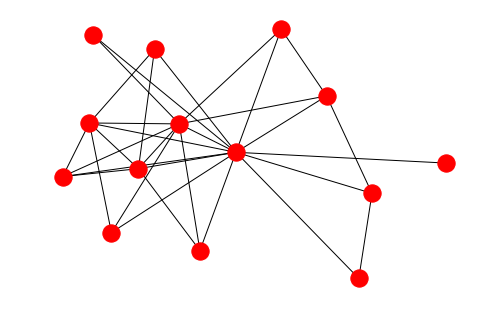

In [5]:
nx.draw(G)

In [6]:
def deg_cent(n):
    return len(list(G.neighbors(n)))

In [7]:
def bonacich_eigen_cent(n):
    n_ = list(G.nodes).index(n)
    L = nx.normalized_laplacian_matrix(G)
    evals, evects = np.linalg.eig(L.A)
    max_eval_ind = np.argmax(evals, axis=0)
    return evects[max_eval_ind, n_]

In [8]:
def alpha_cent(n, alpha=1):
    n_ = list(G.nodes).index(n)
    A = nx.convert_matrix.to_numpy_array(G)
    c_alpha = np.linalg.inv(np.eye(*A.shape) - alpha*A.T)
    e = np.eye(len(G.nodes), 1)
    return float(np.matmul(c_alpha, e)[n_])

def norm_alpha_cent(n, alpha=1):
    cent_fn = partial(alpha_cent, alpha=alpha)
    norm = sum(map(cent_fn, G.nodes))
    return alpha_cent(n) / norm

In [9]:
def closeness_cent(n):
    di = lambda j: nx.shortest_path_length(G, n, j)
    return 1./sum(map(di, G.nodes))

def norm_closeness_cent(n):
    N = len(G.nodes)
    return (N-1) * closeness_cent(n)

In [10]:
CACHE_SIZE = 1000

@lru_cache(maxsize=CACHE_SIZE)
def geodesics(G, n, m):
    return len(list(nx.all_shortest_paths(G, n, m)))

@lru_cache(maxsize=CACHE_SIZE)
def get_paths(G, n, m):
    return nx.all_simple_paths(G, n, m)

@lru_cache(maxsize=CACHE_SIZE)
def geodesics_contains(G, n, m, contain):
    contains = lambda path: contain in path
    paths = get_paths(G, n, m)
    valid_paths = list(filter(contains, paths))
    if not valid_paths: return 0
    shortest_len = min(map(len, valid_paths))
    return len([p for p in valid_paths
                if len(p)==shortest_len])

def between_cent(n):
    total = 0
    for j in G.nodes:
        if n == j: continue
        for k in G.nodes:
            if k in [n, j]: continue
            num = geodesics_contains(G, j, k, n)
            den = geodesics(G, j, k)
            total += float(num) / den
    return total

In [11]:
def delta_cent(n, P):
    G_ = G.copy()
    G_.remove_node(n)
    return (P(G) - P(G_))/P(G)

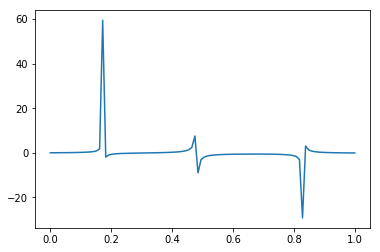

In [13]:
given_node = 2
xs = np.linspace(0, 1, num=100)

plt.plot(xs, [alpha_cent(given_node, a) for a in xs])